# CycleGAN

# Librerías

In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg16
from argparse import Namespace
import torch
from tqdm.auto  import tqdm
import torch.nn as nn
import functools

import matplotlib.pyplot as plt
import numpy as np

import os
from PIL import Image
import random

import torch.optim as optim

import itertools
import os

# Arquitectura

**Discriminador**, función tomada de https://github.com/niranjangavade98/CycleDehaze-Pytorch/blob/master/discriminator.py

In [2]:
class Discriminator(nn.Module):
    """
    Discriminator class
    """
    def __init__(self,inp=3,out=1):
        """
        Initializes the PatchGAN model with 3 layers as discriminator
        Args:
        inp: number of input image channels
        out: number of output image channels
        """

        super(Discriminator, self).__init__()

        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)

        model =    [
                        nn.Conv2d(inp, 64, kernel_size=4, stride=2, padding=1),             #input 3 channels
                        nn.LeakyReLU(0.2,True),

                        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
                        norm_layer(128),
                        nn.LeakyReLU(0.2, True),

                        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
                        norm_layer(256),
                        nn.LeakyReLU(0.2, True),

                        nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=True),
                        norm_layer(512),
                        nn.LeakyReLU(0.2, True),

                        nn.Conv2d(512, out, kernel_size=4, stride=1, padding=1)             #output only 1 channel (prediction map)
                    ]
        self.model = nn.Sequential(*model)

    def forward(self, input):
        """
            Feed forward the image produced by generator through discriminator
            Args:
            input: input image
            Returns:
            outputs prediction map with 1 channel 
        """
        return self.model(input)

**Generador** Esta función se encuentra en https://github.com/niranjangavade98/CycleDehaze-Pytorch/blob/master/generator.py

In [3]:
class Generator(nn.Module):
    """
    Generator model that uses ResNet architecture between upsampling & downsampling layers.
    
    Parms:
    inp        : channels in input image; default=3
    out        : channels in output image; default=3
    res_blocks : number of res-blocks in Resnet; default=6
    """
    def __init__(self,inp = 3,out = 3,res_blocks = 6):
        assert (res_blocks > 0), "There should be atleast 1 ResNet block"
        super(Generator,self).__init__()

        norm_layer = functools.partial(nn.InstanceNorm2d, affine = False, track_running_stats = False)

        model = [
                 nn.ReflectionPad2d(3),                                              #Reflection padding applied to inp image
                 nn.Conv2d(inp, 64, kernel_size=7, padding=0, bias=True),            #7X7 conv applied; 64 filters/output channels
                 norm_layer(64),                                                     #InstanceNorm2D applied
                 nn.ReLU(True),                                                      #Relu activalion applied

                 nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=True),  #downsampling layer-1
                 norm_layer(128),                                                    #
                 nn.ReLU(True),                                                      #

                 nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=True), #downsampling layer-2
                 norm_layer(256),                                                    #
                 nn.ReLU(True),                                                      #
                ]
        
        for _ in range(res_blocks):                                                     #add multiple ResNet blocks
            model +=[
                        ResnetBlock(inp_channels = 256, norm_layer = norm_layer, use_dropout = False)
                    ]


        model +=[nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),  #upsampling layer-1
                 norm_layer(128),                                                                                #
                 nn.ReLU(True),                                                                                  #

                 nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),   #upsampling layer-2
                 norm_layer(64),                                                                                 #
                 nn.ReLU(True),                                                                                  #

                 nn.ReflectionPad2d(3),                                              #Reflection padding applied
                 nn.Conv2d(64, 3, kernel_size=7, padding=0),                         #7X7 conv applied; 3 filters/outputs
                 nn.Tanh()                                                           #Tanh activation function used finally

                ]
            
        self.model = nn.Sequential(*model)

    def forward(self, inp):
        """Standard forward pass"""
        return self.model(inp)
                    

class ResnetBlock(nn.Module):
    """Define a Resnet block
    
    Params:
    inp_channel      : mo. channels given as input; default=3
    norm_layer       : normalisation layer to be used
    use_dropout      : whether to use dropout or not; default=False
    """
    def __init__(self, norm_layer, inp_channels = 256, use_dropout = False):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block ,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        Parameters:
            inp_channels (int)  -- the number of channels in the conv layer.
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers; default=False
        """
        super(ResnetBlock, self).__init__()
        
        res_block =[                                                                    # 1 full Resnet Block
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(inp_channels, inp_channels, kernel_size=3, padding=0, bias=True),
                        norm_layer(inp_channels),
                        nn.ReLU(True),
            
                        #nn.Dropout(0.5),                                               #dont use dropout- Niranjan
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(inp_channels, inp_channels, kernel_size=3, padding=0, bias=True),
                        norm_layer(inp_channels)
                    ]
        
        self.res_block = nn.Sequential(*res_block)

    def forward(self, inp):
        """Forward pass of thos ResNet block only (with skip connections)"""
        out = inp + self.res_block(inp)                                                 # add skip connections
        return out

 **Funciones de pérdida**
 
 Del artículo Engin et al (2018), nos dicen que la función objetivo está definida como 
 
 \begin{equation}
 \mathcal{L} \left(G,F,Dx,Dy \right) = \mathcal{L}_{CycleGAN}\left(G,F,Dx,Dy\right) + \gamma \mathcal{L}_{Perceptual}\left(G,F\right) 
 \end{equation}
 
 Donde $F$ y $G$ son generadores y 
 
 
 \begin{equation}
 \mathcal{L}_{perceptual}\left(G,F,Dx,Dy\right)= | \phi(x)-\phi\left( F(G(x) \right) |_2^2 + | \phi(y)-\phi\left( G(F(y) \right) |_2^2
 \end{equation}
 
 
 

In [4]:
# Loss function of GAN
class L_GANLoss(nn.Module) :
    def __init__(self):
        super(L_GANLoss, self).__init__()
        self.loss   = nn.MSELoss()
        self.device = device
        
    def __call__ (self, dxr, dxf, dyr, dyf) :
        return 0.5 * ( self.loss(dxr, dxf) + self.loss(dyr, dyf)  )

      
    
#Implementamos la función de pérdida de percepción
class Per_loss():
    def __init__(self, devicce):       
        self.vgg16_2 = vgg16(pretrained=True).features[:10].to(device)
        self.vgg16_5 = vgg16(pretrained=True).features.to(device)
        #Error cuadrático medio
        self.loss   = nn.MSELoss()
        self.device = device
        
        for param in self.vgg16_2.parameters():
            param.requires_grad = False
        for param in self.vgg16_5.parameters():
            param.requires_grad = False
            
            # función VGG16
    def phi(self, x):
        phi1 = self.vgg16_2(x).flatten(start_dim = 1)
        phi2 = self.vgg16_5(x).flatten(start_dim = 1)
        return torch.cat([phi1, phi2], dim = 1)
    
    def __call__ (self, x, xp, y, yp):
        return self.loss(self.phi(x), self.phi(xp)) + self.loss(self.phi(y), self.phi(yp))
    
    
#Consictensy loss function
class C_GANLoss(nn.Module) :
    def __init__(self, args) :
        super().__init__()
        self.loss = nn.L1Loss() 
       
    def __call__ (self, X, FGx, Y, GFy) :
        return 0.8 * ( self.loss(X, FGx) + self.loss(Y, GFy) )

# Carga de datos

In [5]:
torch.cuda.set_device(0)

Parámetros globales

In [6]:
args   = Namespace()
args.data        = './data/'
args.batch_size  = 1

In [7]:
device = torch.device('cuda')

In [8]:
class DehazeDataset(Dataset):
    "Dehazing Dataset"
    def __init__(self, root_dir):
        self.root_dir   = root_dir
        self.train_X    = 'raw-890'
        self.train_Y    = 'reference-890'
        self.X_dir_list = os.listdir(os.path.join(self.root_dir, self.train_X))     # get list of image paths in domain X
        self.Y_dir_list = os.listdir(os.path.join(self.root_dir, self.train_Y))     # get list of image paths in domain Y
        
        self.transforms = self.get_transforms()                                     # get transforms to apply to all images


    def __len__(self):
        assert len(self.X_dir_list) == len(self.Y_dir_list), "Number of files in {} & {} are not the same".format(self.train_X,self.train_Y)
        return len(self.X_dir_list)

    def __getitem__(self,index):
        """Return a data point and its metadata information.
        Parameters:
            index (int)      -- a random integer for data indexing
        Returns a dictionary that contains X, Y, X_paths, Y_paths
            X (tensor)       -- an image in the input domain
            Y (tensor)       -- image in the target (randomly chosen)
            X_paths (str)    -- image paths
            Y_paths (str)    -- image paths
        """
        X_img_path = self.X_dir_list[index % len(self.X_dir_list)]  # make sure index is within the range
        # randomize the index for domain Y to avoid fixed pairs.
        ind_Y = random.randint(0, len(self.Y_dir_list) - 1)
        Y_img_path = self.Y_dir_list[ind_Y]
        X_img = Image.open(os.path.join(self.root_dir,self.train_X,X_img_path)).convert('RGB')
        Y_img = Image.open(os.path.join(self.root_dir,self.train_Y,Y_img_path)).convert('RGB')
        # apply image transformation
        X = self.transforms(X_img)
        Y = self.transforms(Y_img)
        return {'X': X, 'Y': Y, 'X_paths': X_img_path, 'Y_paths': Y_img_path}

    def get_transforms(self, resize_to = 286, interpolation = Image.BICUBIC, crop_size = 256):
        """
        Returns 'transforms.Compose object' to apply on images.   Applies resize,randomCrop,
                                                                          randomHorizFlip,toTensor,
                                                                          Normalise
        Args:
            resize_to     : size to resize images
            interpolation : merandom.shuffle(self.X_dir_list)
        random.shuffle(self.Y_dir_list)thod to resize with
            crop_size     : size to crop images
        """
        all_transforms=[]
        all_transforms.append(transforms.Resize(size=(resize_to,resize_to), interpolation=interpolation))
        all_transforms.append(transforms.RandomCrop(crop_size))
        all_transforms.append(transforms.ToTensor())
        all_transforms.append(transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) ))
        return transforms.Compose(all_transforms)
    
    '''
    def get_batch(self, batch_size=7):
        """
        Get a batch of image names from train_X & train_Y of specified batch_size
        Args:
            batch_size : size of batch to return
        """
        assert len(self.X_dir_list) == len(self.Y_dir_list), "Number of files in {} & {} are not the same".format(self.train_X,self.train_Y)
        if self.iter < len(self.X_dir_list):
            if self.iter+batch_size >= len(self.X_dir_list):
                batch_X = self.X_dir_list[self.iter:]
                batch_Y = self.Y_dir_list[self.iter:]
            else:
                batch_X = self.X_dir_list[self.iter:self.iter+batch_size]
                batch_Y = self.Y_dir_list[self.iter:self.iter+batch_size]
            self.iter=self.iter+batch_size
            return batch_X, batch_Y
        else:
            print("All samples from the dataset have been used; please reset the dataset by using <reset_dataset> func")
    def reset_dataset(self):
        """
        Re-shufles train_X & train_Y & sets self.iter to 0
        """
        self.iter=0
        random.shuffle(self.X_dir_list)
        random.shuffle(self.Y_dir_list)
    '''

In [9]:
dataset = DehazeDataset(args.data)

/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [10]:
# create DataLoader
dataloader = DataLoader (dataset, batch_size = args.batch_size)

In [11]:
def show(Im):
    #Resize
    Im = (Im + 1.) * 127.5
    #Squeeze
    Im = np.transpose(Im.squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
    #Print
    plt.imshow(Im)
    plt.show()

Ejemplos

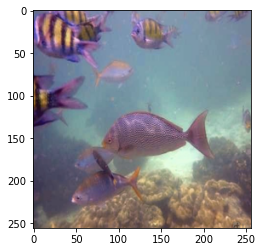

In [12]:
show(dataloader.dataset[100]['Y'])

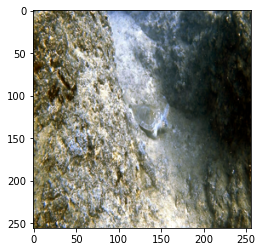

In [13]:
show(dataloader.dataset[40]['Y'])

# Entrenamiento

In [14]:
#Parámetros de la funcioń de pérdida global
args.lam = 3.0
args.gam = .0001

#Parámetros de la red
args.learning_rate = .00001
args.beta1         = 0.6
args.epochs        = 5

#Dataset
args.dataloader = dataloader

Ahora consideremos la función   https://github.com/niranjangavade98/CycleDehaze-Pytorch/blob/master/train.py ajustanto a las funciones de perdida que definimos anteriormente.

In [15]:
def train(agrs):
    
    # parse data from args passed
    data_dir    = args.data
    batch_size  = args.batch_size
    #num_workers = args.num_workers

    #check if data dir exists
    assert os.path.isdir(data_dir), "{} is not a valid directory".format(data_dir)

    # create G, F
    print('Loading Generators(G & F)...')
    G = Generator().to(device)
    F = Generator().to(device)
    print('Generators(G & F) loaded successfully...')

    # create Dx, Dy
    print('Loading Discriminators(Dx, Dy)...')
    Dx = Discriminator().to(device)
    Dy = Discriminator().to(device)
    print('Discriminators(Dx, Dy) loaded successfully...')

    
    # check generator summary
    #print(G)                                        # print Generator
    # check discriminator summary
    #print(Dx)                                       # print Discriminator


    # create 3-loss_functions - Adv_loss, Cycle_consistent_loss, perceptual_loss
    criterionGAN   = C_GANLoss(args).to(device)                                           ############## change device
    criterionCycle = Per_loss(device) 
    criterionIdt   = L_GANLoss().to(device)
    

    # create optimizers
    optimizers = []
    optimizer_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()),   lr = args.learning_rate, betas = (args.beta1, 0.999))
    optimizer_D = optim.Adam(itertools.chain(Dx.parameters(), Dy.parameters()), lr = args.learning_rate, betas = (agrs.beta1, 0.999))
    optimizers.append(optimizer_G)
    optimizers.append(optimizer_D)
    
    loss_CGan_list = []
    losses         = np.array([0., 0., 0., 0.])
            
    # make dataset ready for training
    data_loader = args.dataloader
    
    show(data_loader.dataset[20]['X'])


    # iterate over dataset for training
    for epoch in range(args.epochs):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
        #epoch_start_time = time.time()  # timer for entire epoch
        #iter_data_time = time.time()    # timer for data loading per iteration
        epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
        
        G.train()
        F.train()
        Dx.train()
        Dy.train()
        
        for i, batch in enumerate(tqdm(dataloader)):  # inner loop within one epoch
            optimizers[0].zero_grad()
            optimizers[1].zero_grad()

            X = batch['X'].to(device)
            Y = batch['Y'].to(device)

            Gx      = G(X)
            Dxx     = Dx(X)
            DxGx    = Dx(Gx)
            FGx     = F(Gx)

            Fy      = F(Y)
            Dyy     = Dy(Y)
            DyFy    = Dy(Fy)
            GFy     = G(Fy)
            

            loss_CGan   = criterionGAN(X, FGx, Y, GFy) 
            loss_Id     = criterionIdt(Dxx, DxGx, Dyy, DyFy)
            loss_percep = criterionCycle(Y,GFy, X, FGx)

            loss_CGan_list.append(loss_CGan.detach().item())
            loss_total = loss_Id  + args.lam * loss_CGan + args.gam * loss_percep

            losses[0] += loss_CGan.item()
            losses[1] += loss_Id.item()
            losses[2] += loss_percep.item()
            losses[3] += loss_total.item()


            loss_total.backward()

            optimizers[1].step()
            optimizers[0].step()


        losses /= i+1
        print(f"Total: {losses[-1]:,}\nGAN: {losses[0]:,}  ID: {losses[1]:,}  Percep: {losses[2]:,}")
        losses *= 0.
        
        G.eval()
        im = G(data_loader.dataset[20]['X'].unsqueeze(0).to(device)).detach().cpu()
        show(im)

Loading Generators(G & F)...
Generators(G & F) loaded successfully...
Loading Discriminators(Dx, Dy)...
Discriminators(Dx, Dy) loaded successfully...


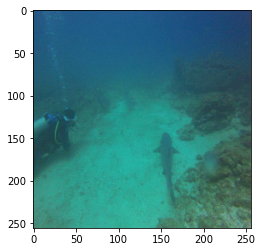

  0%|          | 0/890 [00:00<?, ?it/s]

/home/esteban/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Total: 1.245346163497882
GAN: 0.4066613255591875  ID: 0.02458890088574877  Percep: 7.732866065689687


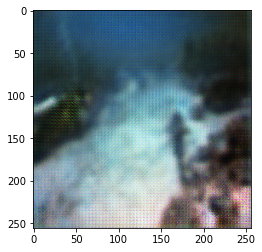

  0%|          | 0/890 [00:00<?, ?it/s]

Total: 0.9790786045990633
GAN: 0.3256543517615018  ID: 0.001472079692070969  Percep: 6.434747290879153


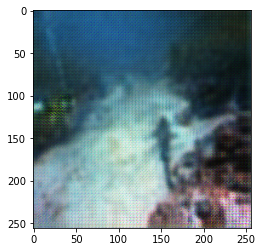

  0%|          | 0/890 [00:00<?, ?it/s]

Total: 0.9148119670286607
GAN: 0.3045439730534393  ID: 0.0005777786769776662  Percep: 6.022721912619773


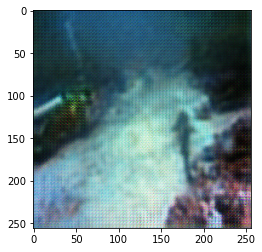

  0%|          | 0/890 [00:00<?, ?it/s]

Total: 0.8620750809988279
GAN: 0.28705738200230546  ID: 0.00031370595369368317  Percep: 5.892315463537581


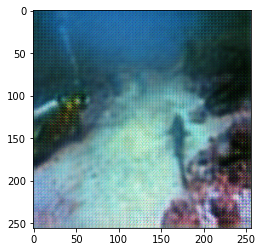

  0%|          | 0/890 [00:00<?, ?it/s]

Total: 0.841132672482662
GAN: 0.28012169346715626  ID: 0.00019228737618596936  Percep: 5.7530708357189475


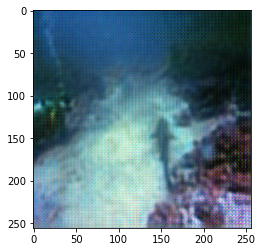

In [16]:
train(args)

Observamos que a pesar de que quitó la niebla, la resolución de las imágenes se redujo notoriamente. esto puede ser causado por el parámetro tanto de las funciones de pérdida como los la red(parámetros globales) también que ppor el tiempo sólo hubo oportunidad de hacer 5 épocas y cada una con bath unitario p